In [61]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision.io import read_image
import torchvision.transforms.v2 as transformsv2
import sys
torch.manual_seed(42)

sys.path.append("..")

RESNET18_HEIGHT = 224
RESNET18_WIDTH = 224

class RFW(Dataset):

    def __init__(self, img_path, attr_path, transforms, png):

        self.attr = pd.read_csv(attr_path).to_numpy()
        print(f'attr: {self.attr}')
        self.img_path = img_path
        self.transforms = transforms
        self.png = png
        
    def __len__(self):
        return len(self.attr)
    
    def __getitem__(self, idx):

        if self.png:
            img =  read_image(os.path.join(self.img_path, self.attr[idx][2], self.attr[idx][1]))
        else:
            img =  read_image(os.path.join(self.img_path, self.attr[idx][2], self.attr[idx][1].replace("png", "jpg")))
        return self.transforms(img), torch.from_numpy(self.attr[idx][3:].astype(np.float32)),\
            self.attr[idx][2].split("/")[0], f'{self.attr[idx][2]}/{self.attr[idx][1]}'



def create_dataloaders(
    img_path, 
    attr_path, 
    batch_size, 
    train_test_ratio=0.7, 
    png=True, 
    seed=42
):

    tfs = transformsv2.Compose([
        transformsv2.Resize((RESNET18_HEIGHT, RESNET18_WIDTH)),
        transformsv2.ToTensor()
    ])

    # Create Dataset
    data = RFW(img_path, attr_path, tfs, png)

    generator = torch.Generator().manual_seed(seed)

    trainset_size = int(len(data) * train_test_ratio)
    validaset_size = int((len(data) - trainset_size) * 0.5)
    testset_size = len(data) - trainset_size - validaset_size

    trainset, valset, testset = random_split(data, [trainset_size, validaset_size, testset_size], generator)

    # Create data loaders
    train_loader = DataLoader(trainset, batch_size, shuffle=True)
    val_loader = DataLoader(valset, batch_size)
    test_loader = DataLoader(testset, batch_size)

    return train_loader, val_loader, test_loader

In [62]:
RACE_LABELS = ['Indian', 'Asian', 'African', 'Caucasian']
ROOT = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64'
RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels_sorted.csv"
RATIO = 0.8
BATCH_SIZE = 32
model_names = ['cheng2020-attn', 'hyperprior', 'mbt2018', 'qarv', 'qres17m']
attribites = ['']
model_name = 'cheng2020-attn'
datasets_names = ['fairface', 'celebA']
dataset_name = 'celebA'

qualities = ['q_0001', 'q_0009', 'q_1', 'q_2', 'q_3']
for quality in qualities:
    train_loader, valid_loader, test_loader = create_dataloaders(
        f'{ROOT}/{model_name}/{dataset_name}/{quality}', 
        RFW_LABELS_DIR, 
        BATCH_SIZE, 
        RATIO
    )

attr: [[0 'm.011y5k_0003.png' 'African/m.011y5k' ... 1 1 0]
 [1 'm.011y5k_0004.png' 'African/m.011y5k' ... 1 1 0]
 [2 'm.011y5k_0002.png' 'African/m.011y5k' ... 1 1 0]
 ...
 [40604 'm.0_4pw_0004.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40605 'm.0_4pw_0003.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40606 'm.0_4pw_0002.png' 'Indian/m.0_4pw' ... 1 2 0]]
attr: [[0 'm.011y5k_0003.png' 'African/m.011y5k' ... 1 1 0]
 [1 'm.011y5k_0004.png' 'African/m.011y5k' ... 1 1 0]
 [2 'm.011y5k_0002.png' 'African/m.011y5k' ... 1 1 0]
 ...
 [40604 'm.0_4pw_0004.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40605 'm.0_4pw_0003.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40606 'm.0_4pw_0002.png' 'Indian/m.0_4pw' ... 1 2 0]]
attr: [[0 'm.011y5k_0003.png' 'African/m.011y5k' ... 1 1 0]
 [1 'm.011y5k_0004.png' 'African/m.011y5k' ... 1 1 0]
 [2 'm.011y5k_0002.png' 'African/m.011y5k' ... 1 1 0]
 ...
 [40604 'm.0_4pw_0004.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40605 'm.0_4pw_0003.png' 'Indian/m.0_4pw' ... 1 2 0]
 [40606 'm.0_4pw_0002.png' 'Indian/m.0_

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transf

In [64]:
test_file_names = []
for batch in test_loader:
    test_file_names.extend(list(batch[-1]))

In [65]:
test_file_names

['Caucasian/m.04vzp3/m.04vzp3_0005.png',
 'Asian/m.06jvdd/m.06jvdd_0002.png',
 'Caucasian/m.068p19/m.068p19_0002.png',
 'African/m.09876j/m.09876j_0003.png',
 'Caucasian/m.03f1sjy/m.03f1sjy_0002.png',
 'Asian/m.02rzm97/m.02rzm97_0002.png',
 'African/m.01mvw82/m.01mvw82_0003.png',
 'Caucasian/m.0gbx3b6/m.0gbx3b6_0004.png',
 'Indian/m.0h1sgs/m.0h1sgs_0003.png',
 'African/m.01mjyj0/m.01mjyj0_0003.png',
 'African/m.0j3vxkv/m.0j3vxkv_0002.png',
 'African/m.026_y13/m.026_y13_0004.png',
 'Caucasian/m.03plx_/m.03plx__0001.png',
 'Asian/m.06c1fd/m.06c1fd_0004.png',
 'Caucasian/m.04dyc2/m.04dyc2_0003.png',
 'Caucasian/m.026ths5/m.026ths5_0002.png',
 'Indian/m.060dvc/m.060dvc_0002.png',
 'Indian/m.02qytnc/m.02qytnc_0001.png',
 'Indian/m.025xfy6/m.025xfy6_0004.png',
 'Asian/m.07pkn7/m.07pkn7_0002.png',
 'African/m.03_w4m/m.03_w4m_0002.png',
 'Indian/m.04q699/m.04q699_0001.png',
 'African/m.04lxlw/m.04lxlw_0003.png',
 'Indian/m.0c7wt7/m.0c7wt7_0001.png',
 'Asian/m.0c6c6x/m.0c6c6x_0004.png',
 'Afric

In [79]:
from tqdm import tqdm

ATTRIBUTE_INDECIES = {
    'skin_type': 0,
    'lip_type': 1,
    'nose_type': 2,
    'eye_type': 3,
    'hair_type': 4,
    'hair_color': 5
}

def save_race_based_predictions(
        models,  
        dataloader, 
        device, 
        prediction_save_dir,
        attributes
    ):
    all_predictions = {'Indian': {attr: torch.tensor([]) for attr in attributes}, 
                       'Caucasian': {attr: torch.tensor([]) for attr in attributes}, 
                       'Asian': {attr: torch.tensor([]) for attr in attributes},  
                       'African': {attr: torch.tensor([]) for attr in attributes}}
    all_labels = {'Indian': {attr: torch.tensor([]) for attr in attributes}, 
                  'Caucasian': {attr: torch.tensor([]) for attr in attributes}, 
                  'Asian': {attr: torch.tensor([]) for attr in attributes}, 
                  'African': {attr: torch.tensor([]) for attr in attributes}}
    all_file_names = {
        'Indian': {attr: [] for attr in attributes}, 
        'Caucasian': {attr: [] for attr in attributes}, 
        'Asian': {attr: [] for attr in attributes},  
        'African': {attr: [] for attr in attributes}
    }
    print(f'prediction_save_dir: {prediction_save_dir}')
    dataloader = tqdm(dataloader, desc="Getting Predictions", unit="batch")
    with torch.no_grad():
        for j, model in enumerate(models):
            model.eval()
            for _, data in enumerate(dataloader):
                inputs, labels, race, file_names = data
                file_names = np.array(list(file_names))
                race = np.array(race)

                inputs = inputs.to(torch.float).to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                for i, (head, predictions) in enumerate(outputs.items()):
                    head_preds = predictions.argmax(dim=1).cpu()

                    for race_label in all_labels:
                        race_indices = np.array((race == race_label).nonzero()[0])
                        race_predictions = head_preds[race_indices]
                        race_file_names = file_names[race_indices]
                        race_labels = labels[:, ATTRIBUTE_INDECIES[head]][race_indices]
                    
                        all_predictions[race_label][head] = torch.cat((all_predictions[race_label][head], race_predictions.to('cpu')), dim=0)
                        all_labels[race_label][head] = torch.cat((all_labels[race_label][head], race_labels.to('cpu')), dim=0)
                        all_file_names[race_label][head].extend(list(race_file_names))
    # with open(prediction_save_dir + '/sep_predictions.pkl', 'wb+') as f:
    #     pickle.dump(all_predictions, f)
    # with open(prediction_save_dir + '/sep_labels.pkl', 'wb+') as f:
    #     pickle.dump(all_labels, f)


    return all_predictions, all_labels, all_file_names

In [80]:
import pickle
from multi_head_resnet import MultiHeadResNet
all_predictions = {}
all_labels = {}
all_file_names = {}
attributes = ['eye_type', 'hair_color', 'hair_type', 'nose_type', 'skin_type']
PRED_ROOT = '/media/global_data/fair_neural_compression_data/predictions'
for model in model_names:
    all_predictions[model_name] = {}
    all_labels[model_name] = {}
    all_file_names[model_name] = {}
    for quality in qualities:
        models = []
        for attribute in attributes:
            attribute_model_path = f'{PRED_ROOT}/{model_name}/{dataset_name}/{quality}/{attribute}_best.pth'
            models.append(torch.load(attribute_model_path))
        all_file_names[model_name][quality], \
        all_labels[model_name][quality] = \
        all_predictions[model_name][quality], \
            save_race_based_predictions(
                models,  
                test_loader, 
                'cuda:1', 
                "",
                attributes
            )
        # preds_path = f'{PRED_ROOT}/{model}/{dataset_name}/{quality}/sep_predictions.pkl'
        # labels_path = f'{PRED_ROOT}/{model}/{dataset_name}/{quality}/sep_labels.pkl'
        # with open(preds_path, 'rb') as file:
        #     all_predictions[model_name][quality] = pickle.load(file)
            
        # with open(labels_path, 'rb') as file:
        #     all_labels[model_name][quality] = pickle.load(file)
        

prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.82batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.27batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.83batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.70batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.58batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.80batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.57batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.77batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 39.81batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 39.88batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.60batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.71batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.48batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.70batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.47batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.58batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.71batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.65batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.42batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.43batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.62batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.71batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.66batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.51batch/s]


prediction_save_dir: 


Getting Predictions: 100%|██████████| 127/127 [00:03<00:00, 40.50batch/s]


In [94]:
# temp = all_file_names 
# all_file_names = all_labels
# all_labels = temp

In [95]:
cheng_preds, cheng_labels = all_predictions['cheng2020-attn'], all_labels['cheng2020-attn']

In [96]:
cheng_file_names = all_file_names['cheng2020-attn']

In [85]:
cheng_labels[quality][race][attribute]

['Indian/m.0h1sgs/m.0h1sgs_0003.png',
 'Indian/m.060dvc/m.060dvc_0002.png',
 'Indian/m.02qytnc/m.02qytnc_0001.png',
 'Indian/m.025xfy6/m.025xfy6_0004.png',
 'Indian/m.04q699/m.04q699_0001.png',
 'Indian/m.0c7wt7/m.0c7wt7_0001.png',
 'Indian/m.08r_r8/m.08r_r8_0002.png',
 'Indian/m.0288m_h/m.0288m_h_0001.png',
 'Indian/m.0g54n2/m.0g54n2_0003.png',
 'Indian/m.0g5t3r1/m.0g5t3r1_0001.png',
 'Indian/m.029t5l/m.029t5l_0003.png',
 'Indian/m.0ndwnjc/m.0ndwnjc_0003.png',
 'Indian/m.0520f23/m.0520f23_0001.png',
 'Indian/m.03h0bdk/m.03h0bdk_0003.png',
 'Indian/m.05p7pq/m.05p7pq_0002.png',
 'Indian/m.0fph9sg/m.0fph9sg_0003.png',
 'Indian/m.0j9p5_f/m.0j9p5_f_0003.png',
 'Indian/m.0fzxp3/m.0fzxp3_0001.png',
 'Indian/m.0cyws4/m.0cyws4_0001.png',
 'Indian/m.0fq2084/m.0fq2084_0003.png',
 'Indian/m.0h_d32_/m.0h_d32__0002.png',
 'Indian/m.03cbz21/m.03cbz21_0002.png',
 'Indian/m.09rvdzt/m.09rvdzt_0002.png',
 'Indian/m.0g9txr9/m.0g9txr9_0002.png',
 'Indian/m.0hzrn7d/m.0hzrn7d_0003.png',
 'Indian/m.0274f0x/m

In [97]:
wrong_preds_file_names = {}

for quality in qualities:
    wrong_preds_file_names[quality] = {}
    for race in RACE_LABELS:
        wrong_preds_file_names[quality][race] = {}
        for attribute in attributes:
            mask = torch.ne(cheng_preds[quality][race][attribute], cheng_labels[quality][race][attribute])
            wrong_preds_file_names[quality][race][attribute] = \
                np.array(cheng_file_names[quality][race][attribute])[np.array(torch.nonzero(mask).squeeze())]

In [98]:
race_of_interest = 'Asian'
attribute_of_interest = 'eye_type'
wrong_preds_of_interest = {} # index: Last quality that was incorrect

for quality in qualities:
    temp_wrong_preds = {}
    new_wrong_preds = set(wrong_preds_file_names[quality][race_of_interest][attribute_of_interest])
    wrong_preds_indices = set(wrong_preds_of_interest.keys())
    
    wrong_preds_indices = list(new_wrong_preds.symmetric_difference(wrong_preds_indices))
    for wrong_preds_index in wrong_preds_indices:
        if wrong_preds_index in wrong_preds_of_interest:
            temp_wrong_preds[wrong_preds_index] = wrong_preds_of_interest[wrong_preds_index]
        else:
            temp_wrong_preds[wrong_preds_index] = quality
    wrong_preds_of_interest = temp_wrong_preds
wrong_preds_of_interest

{'Asian/m.0sgqn3w/m.0sgqn3w_0004.png': 'q_0001',
 'Asian/m.03gw36m/m.03gw36m_0003.png': 'q_3',
 'Asian/m.0668qy/m.0668qy_0005.png': 'q_3',
 'Asian/m.03f0cxl/m.03f0cxl_0003.png': 'q_3',
 'Asian/m.0gjdzm4/m.0gjdzm4_0004.png': 'q_3',
 'Asian/m.04jmt35/m.04jmt35_0003.png': 'q_3',
 'Asian/m.04mtkk/m.04mtkk_0003.png': 'q_3',
 'Asian/m.01ym6z/m.01ym6z_0002.png': 'q_0009',
 'Asian/m.04glpb0/m.04glpb0_0004.png': 'q_3',
 'Asian/m.03cgdt5/m.03cgdt5_0002.png': 'q_3',
 'Asian/m.02q1nn/m.02q1nn_0001.png': 'q_3',
 'Asian/m.02pxk30/m.02pxk30_0002.png': 'q_3',
 'Asian/m.047sm3j/m.047sm3j_0003.png': 'q_3',
 'Asian/m.04_r1c/m.04_r1c_0002.png': 'q_0001',
 'Asian/m.0262_mx/m.0262_mx_0004.png': 'q_3',
 'Asian/m.0gy1zf9/m.0gy1zf9_0002.png': 'q_3',
 'Asian/m.061lnp/m.061lnp_0001.png': 'q_3',
 'Asian/m.0czd0f0/m.0czd0f0_0003.png': 'q_3',
 'Asian/m.0bjvm9/m.0bjvm9_0004.png': 'q_1',
 'Asian/m.026bfbd/m.026bfbd_0002.png': 'q_3',
 'Asian/m.0fqy6jb/m.0fqy6jb_0002.png': 'q_3',
 'Asian/m.0ryvxtg/m.0ryvxtg_0004.png': 

In [99]:
len(wrong_preds_of_interest)

419

['Asian/m.0djhq4/m.0djhq4_0001.png', 'Asian/m.0bx_ks/m.0bx_ks_0005.png', 'Asian/m.03chhr/m.03chhr_0004.png', 'Asian/m.0cnyjks/m.0cnyjks_0003.png', 'Asian/m.0jvvbfb/m.0jvvbfb_0003.png', 'Asian/m.0nddhwx/m.0nddhwx_0002.png', 'Asian/m.03dkc7/m.03dkc7_0001.png', 'Asian/m.04mtkk/m.04mtkk_0003.png', 'Asian/m.0bkfkm/m.0bkfkm_0002.png', 'Asian/m.07g_m9/m.07g_m9_0001.png']
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.0djhq4/m.0djhq4_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.0djhq4/m.0djhq4_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.0djhq4/m.0djhq4_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.0djhq4/m.0djhq4_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA

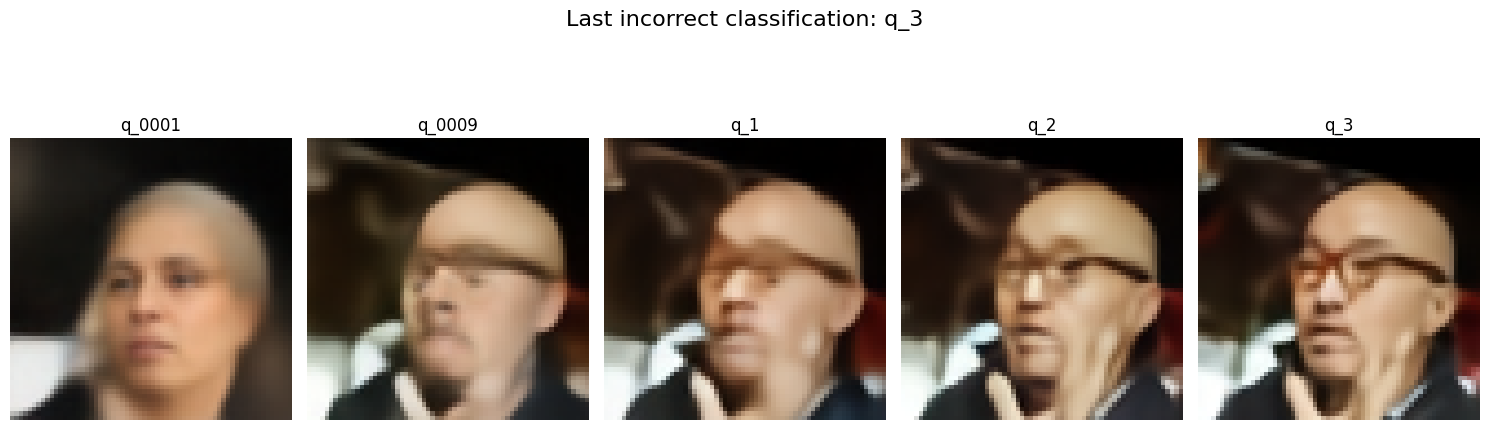

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.0bx_ks/m.0bx_ks_0005.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.0bx_ks/m.0bx_ks_0005.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.0bx_ks/m.0bx_ks_0005.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.0bx_ks/m.0bx_ks_0005.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Asian/m.0bx_ks/m.0bx_ks_0005.png


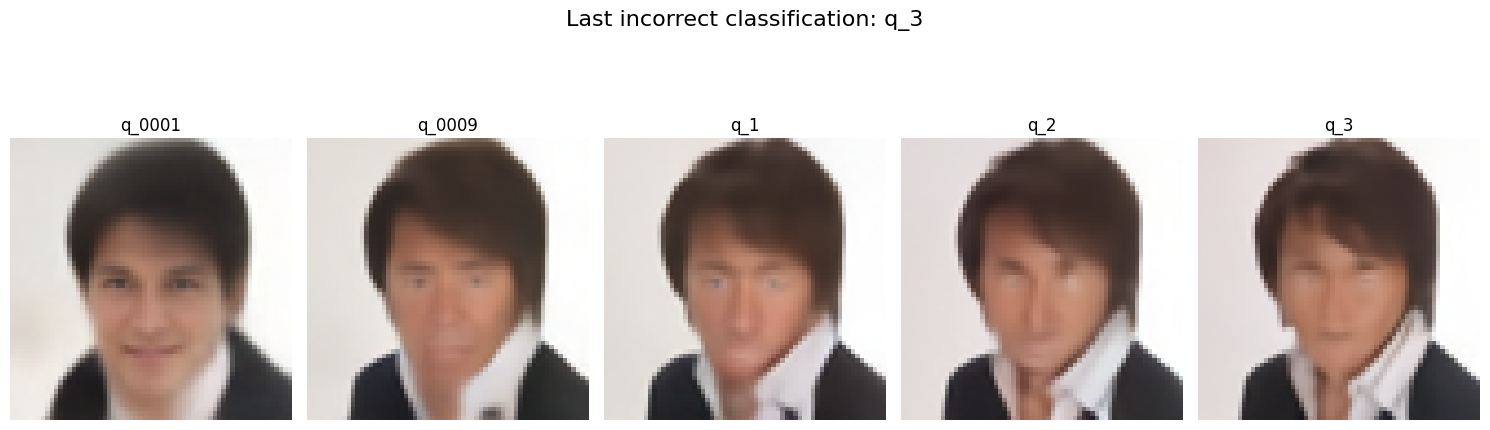

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.03chhr/m.03chhr_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.03chhr/m.03chhr_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.03chhr/m.03chhr_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.03chhr/m.03chhr_0004.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Asian/m.03chhr/m.03chhr_0004.png


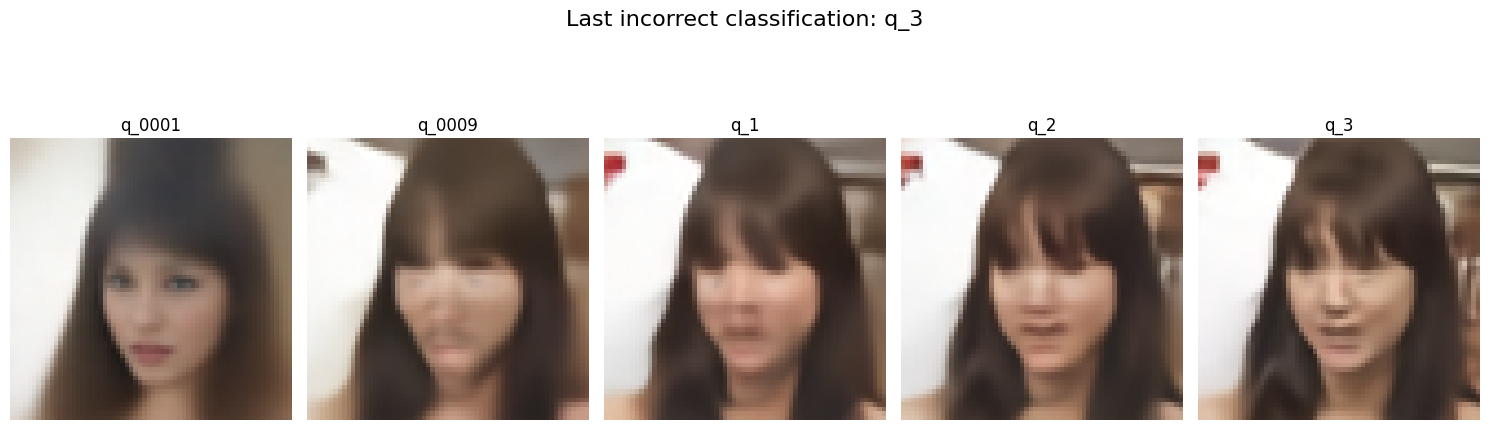

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.0cnyjks/m.0cnyjks_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.0cnyjks/m.0cnyjks_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.0cnyjks/m.0cnyjks_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.0cnyjks/m.0cnyjks_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Asian/m.0cnyjks/m.0cnyjks_0003.png


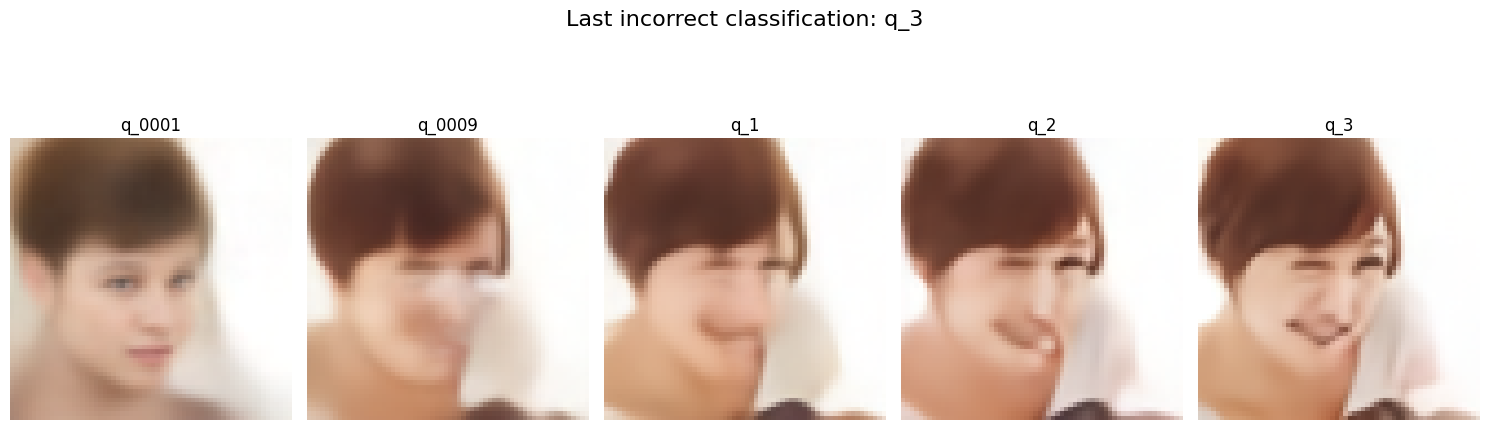

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.0jvvbfb/m.0jvvbfb_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.0jvvbfb/m.0jvvbfb_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.0jvvbfb/m.0jvvbfb_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.0jvvbfb/m.0jvvbfb_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Asian/m.0jvvbfb/m.0jvvbfb_0003.png


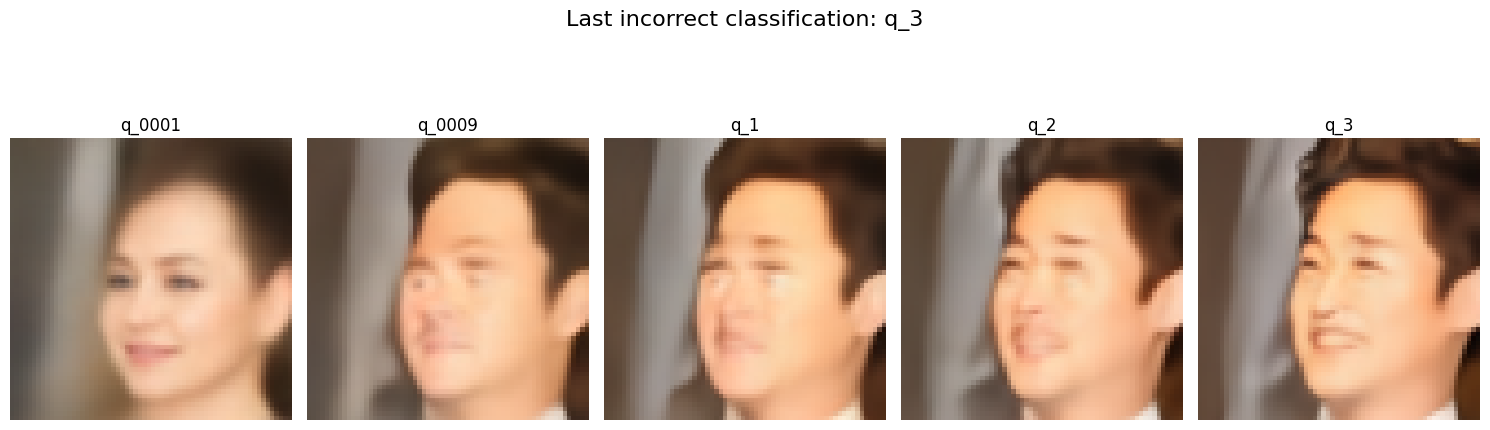

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.0nddhwx/m.0nddhwx_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.0nddhwx/m.0nddhwx_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.0nddhwx/m.0nddhwx_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.0nddhwx/m.0nddhwx_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Asian/m.0nddhwx/m.0nddhwx_0002.png


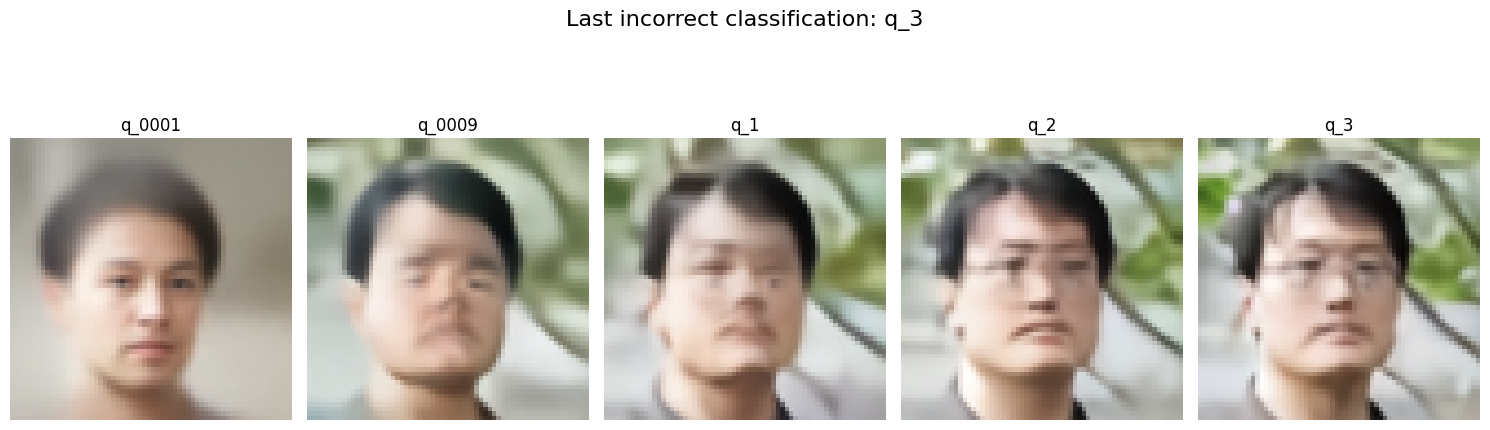

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.03dkc7/m.03dkc7_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.03dkc7/m.03dkc7_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.03dkc7/m.03dkc7_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.03dkc7/m.03dkc7_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Asian/m.03dkc7/m.03dkc7_0001.png


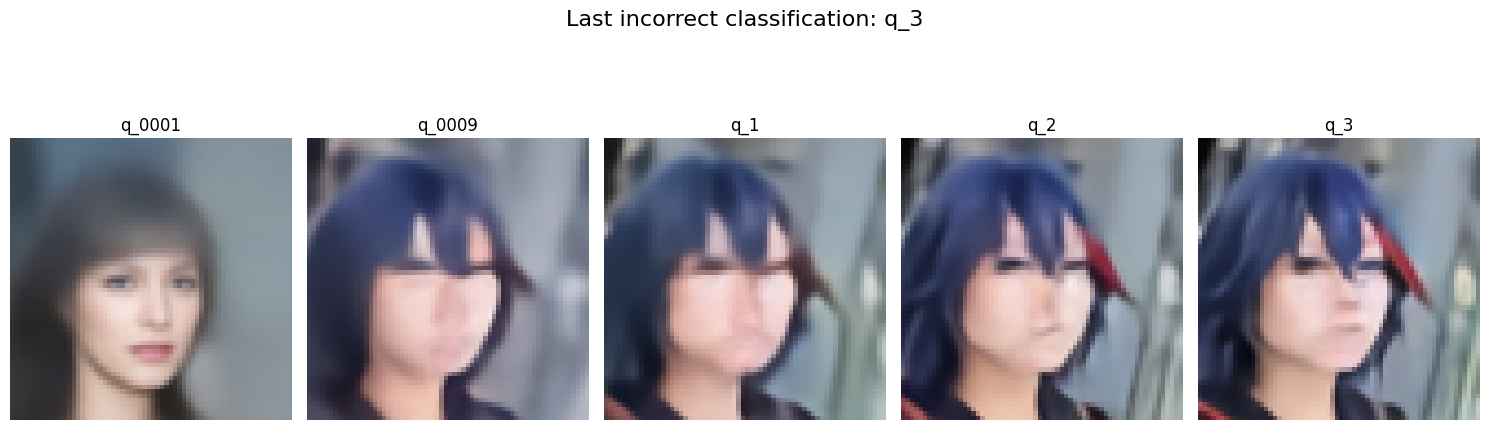

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.04mtkk/m.04mtkk_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.04mtkk/m.04mtkk_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.04mtkk/m.04mtkk_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.04mtkk/m.04mtkk_0003.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Asian/m.04mtkk/m.04mtkk_0003.png


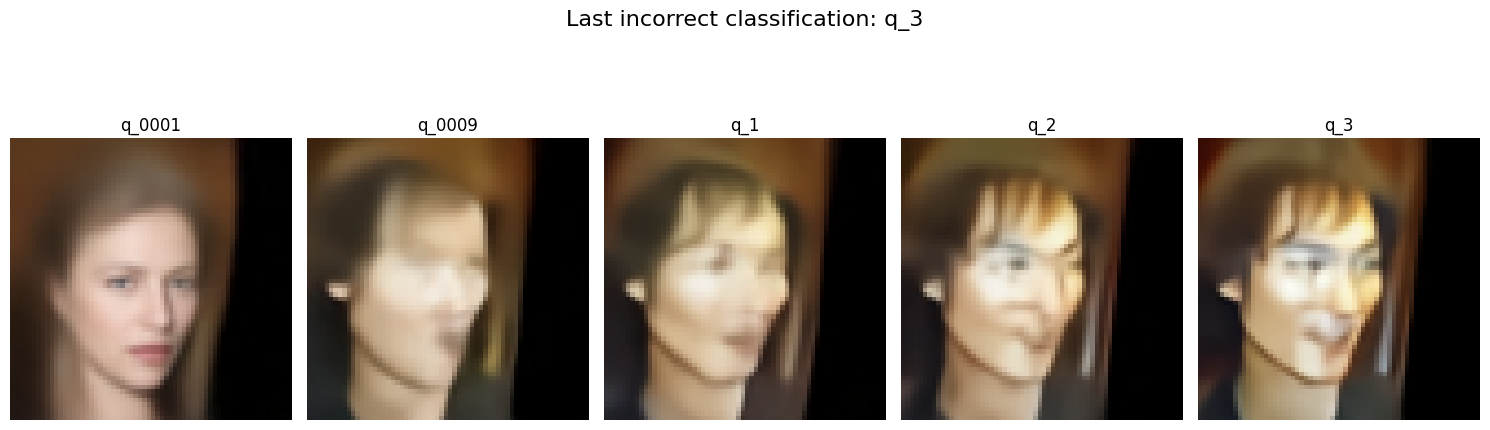

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.0bkfkm/m.0bkfkm_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.0bkfkm/m.0bkfkm_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.0bkfkm/m.0bkfkm_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.0bkfkm/m.0bkfkm_0002.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Asian/m.0bkfkm/m.0bkfkm_0002.png


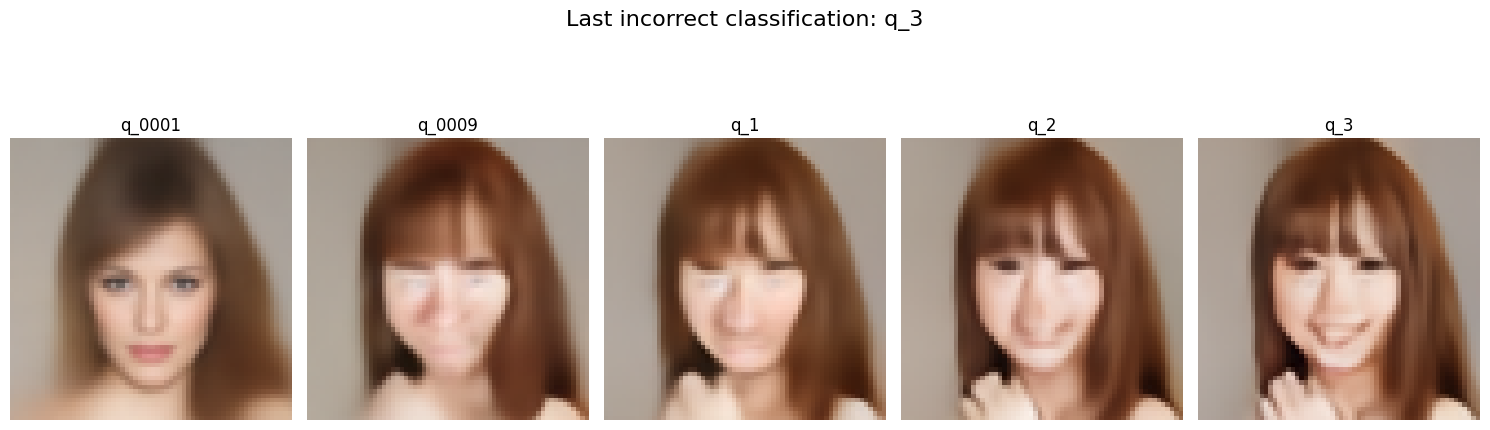

/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0001/Asian/m.07g_m9/m.07g_m9_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_0009/Asian/m.07g_m9/m.07g_m9_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_1/Asian/m.07g_m9/m.07g_m9_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_2/Asian/m.07g_m9/m.07g_m9_0001.png
/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/cheng2020-attn/celebA/q_3/Asian/m.07g_m9/m.07g_m9_0001.png


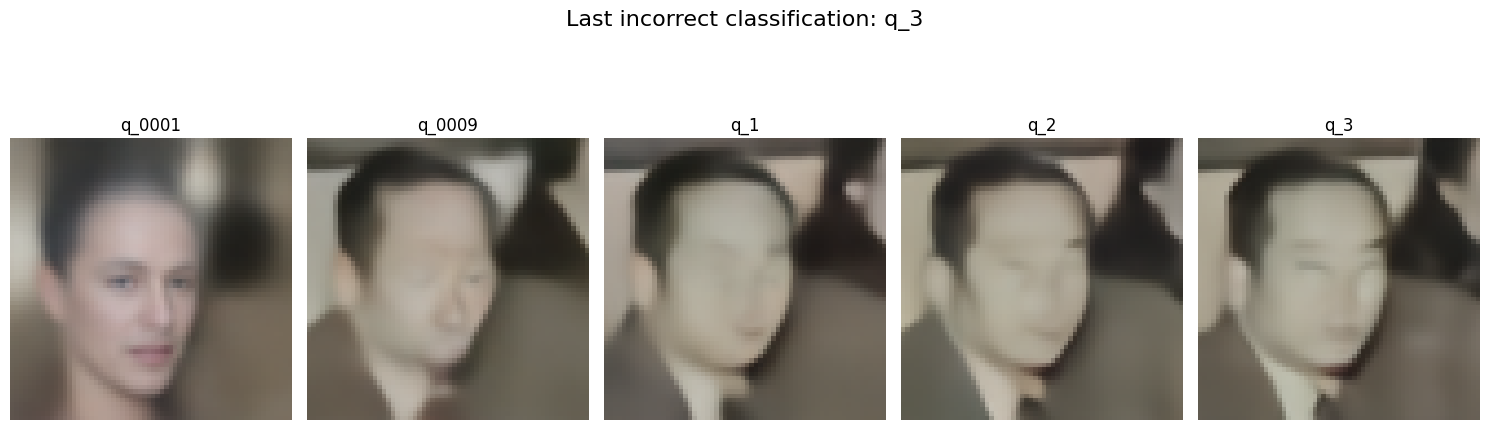

In [101]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


selected_keys = random.sample(list(wrong_preds_of_interest.keys()), 10)
print(selected_keys)

for file_name in selected_keys:
    wrong_pred_quality = wrong_preds_of_interest[file_name]
    image_files = []
    for quality in qualities:
        image_files.append(f'{ROOT}/{"cheng2020-attn"}/{dataset_name}/{quality}/{file_name}')
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, ax in enumerate(axes):
        print(f'{image_files[i]}')
        img = mpimg.imread(image_files[i])
        ax.imshow(img)
        ax.set_title(qualities[i])
        ax.axis('off')
    fig.suptitle(f'Last incorrect classification: {wrong_pred_quality}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the top to fit the suptitle

    # Show the plot
    plt.show()


In [30]:
RFW_ROOT = '/media/global_data/fair_neural_compression_data/datasets/RFW/data_64'

'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64'

In [29]:
test_file_names

['Caucasian/m.04vzp3/m.04vzp3_0005.png',
 'Asian/m.06jvdd/m.06jvdd_0002.png',
 'Caucasian/m.068p19/m.068p19_0002.png',
 'African/m.09876j/m.09876j_0003.png',
 'Caucasian/m.03f1sjy/m.03f1sjy_0002.png',
 'Asian/m.02rzm97/m.02rzm97_0002.png',
 'African/m.01mvw82/m.01mvw82_0003.png',
 'Caucasian/m.0gbx3b6/m.0gbx3b6_0004.png',
 'Indian/m.0h1sgs/m.0h1sgs_0003.png',
 'African/m.01mjyj0/m.01mjyj0_0003.png',
 'African/m.0j3vxkv/m.0j3vxkv_0002.png',
 'African/m.026_y13/m.026_y13_0004.png',
 'Caucasian/m.03plx_/m.03plx__0001.png',
 'Asian/m.06c1fd/m.06c1fd_0004.png',
 'Caucasian/m.04dyc2/m.04dyc2_0003.png',
 'Caucasian/m.026ths5/m.026ths5_0002.png',
 'Indian/m.060dvc/m.060dvc_0002.png',
 'Indian/m.02qytnc/m.02qytnc_0001.png',
 'Indian/m.025xfy6/m.025xfy6_0004.png',
 'Asian/m.07pkn7/m.07pkn7_0002.png',
 'African/m.03_w4m/m.03_w4m_0002.png',
 'Indian/m.04q699/m.04q699_0001.png',
 'African/m.04lxlw/m.04lxlw_0003.png',
 'Indian/m.0c7wt7/m.0c7wt7_0001.png',
 'Asian/m.0c6c6x/m.0c6c6x_0004.png',
 'Afric